In [1]:
from datasets import load_dataset

ds = load_dataset("universeTBD/arxiv-bit-flip-cs.LG")

Generating train split:   0%|          | 0/100039 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['bit', 'flip', 'title', 'categories', 'abstract', 'authors', 'doi', 'id'],
        num_rows: 100039
    })
})

In [3]:
from datasets import load_dataset

hypo = load_dataset("charlieoneill/hypogen-data")

Generating train split:   0%|          | 0/46030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/709 [00:00<?, ? examples/s]

In [4]:
hypo

DatasetDict({
    train: Dataset({
        features: ['title', 'authors', 'abstract', 'year', 'venue', 'bit_flip_spark'],
        num_rows: 46030
    })
    test: Dataset({
        features: ['title', 'authors', 'abstract', 'year', 'venue', 'bit_flip_spark'],
        num_rows: 709
    })
})

In [6]:
from datasets import concatenate_datasets, DatasetDict
import pandas as pd

def normalize_authors(example):
    if isinstance(example['authors'], list):
        return {'authors': ', '.join(example['authors'])}
    return {'authors': str(example['authors'])}

# Normalize authors in each dataset
ds['train'] = ds['train'].map(normalize_authors)
hypo['train'] = hypo['train'].map(normalize_authors)
hypo['test'] = hypo['test'].map(normalize_authors)

# Convert to pandas DataFrames
df1 = ds['train'].to_pandas()
df2 = hypo['train'].to_pandas()
df3 = hypo['test'].to_pandas()

# Combine all dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Deduplicate based on title
deduplicated_df = combined_df.drop_duplicates(subset='title', keep='first')

# Convert back to a Dataset
from datasets import Dataset
final_dataset = Dataset.from_pandas(deduplicated_df)

# Create a new DatasetDict with the deduplicated dataset
final_dataset_dict = DatasetDict({'train': final_dataset})

# Print some information about the final dataset
print(f"Number of rows in final dataset: {len(final_dataset_dict['train'])}")
print(f"Features in final dataset: {final_dataset_dict['train'].features}")

Map:   0%|          | 0/100039 [00:00<?, ? examples/s]

Map:   0%|          | 0/46030 [00:00<?, ? examples/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Number of rows in final dataset: 141518
Features in final dataset: {'bit': Value(dtype='string', id=None), 'flip': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'categories': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'authors': Value(dtype='string', id=None), 'doi': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'year': Value(dtype='float64', id=None), 'venue': Value(dtype='string', id=None), 'bit_flip_spark': {'bit': Value(dtype='string', id=None), 'flip': Value(dtype='string', id=None), 'spark': Value(dtype='string', id=None)}, '__index_level_0__': Value(dtype='int64', id=None)}


In [21]:
features = [x for x in list(final_dataset.features.keys()) if x not in ['bit', 'flip', 'bit_flip_spark', '__index_level_0__']]
final_dataset = final_dataset.remove_columns(['bit', 'flip', 'bit_flip_spark', '__index_level_0__'])
final_dataset

Dataset({
    features: ['title', 'categories', 'abstract', 'authors', 'doi', 'id', 'year', 'venue'],
    num_rows: 141518
})

In [22]:
final_dataset.push_to_hub('charlieoneill/cs.LG')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/142 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/charlieoneill/cs.LG/commit/2074bc9c018085e0e3c94594c7928deaf5c377d6', commit_message='Upload dataset', commit_description='', oid='2074bc9c018085e0e3c94594c7928deaf5c377d6', pr_url=None, pr_revision=None, pr_num=None)

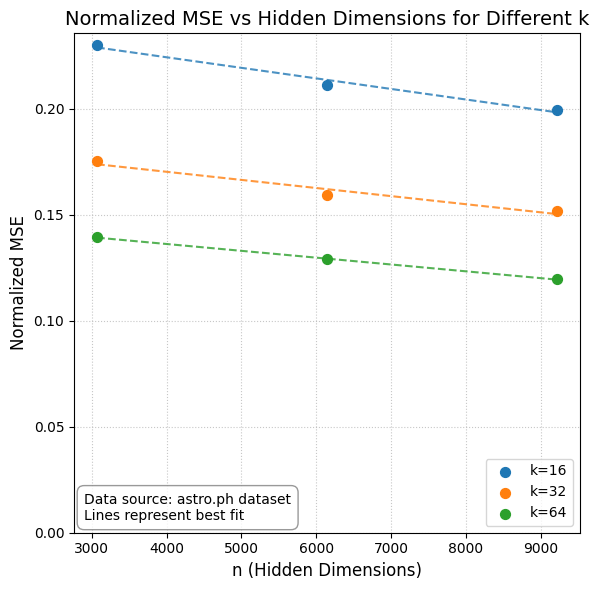

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [16, 32, 64]
n_values = [3072, 6144, 9216]
mse_values = {
    16: [0.2300, 0.2113, 0.1994],
    32: [0.1751, 0.1594, 0.1516],
    64: [0.1393, 0.1290, 0.1195]
}

# Set up the plot
plt.figure(figsize=(6, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot data and fit lines
for i, k in enumerate(k_values):
    x = n_values
    y = mse_values[k]
    
    # Plot scatter points
    plt.scatter(x, y, color=colors[i], s=50, zorder=3, label=f'k={k}')
    
    # Fit a line
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    
    # Plot the line of best fit
    x_line = np.linspace(min(x), max(x), 100)
    plt.plot(x_line, poly(x_line), color=colors[i], linestyle='--', alpha=0.8)

# Customize the plot
plt.xlabel('n (Hidden Dimensions)', fontsize=12)
plt.ylabel('Normalized MSE', fontsize=12)
plt.title('Normalized MSE vs Hidden Dimensions for Different k', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=10)

# Set y-axis to start from 0
plt.ylim(bottom=0)

# Add a text box with information
plt.text(0.02, 0.02, 'Data source: astro.ph dataset\nLines represent best fit', 
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.show()

## Abstract embeddings

In [27]:
import numpy as np
import pickle
import json
from typing import List
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class Document:
    id: str
    abstract: str
    #conclusions: str
    id: str
    title: str = None
    n_citation: int = None
    keywords: List[str] = None

# Load the full embeddings matrix
embeddings = np.load('../data/vector_store_csLG/embeddings_matrix.npy')

# Load the index mapping
with open('../data/vector_store_csLG/index_mapping.pkl', 'rb') as f:
    index_mapping = pickle.load(f)

# Load the documents
with open('../data/vector_store_csLG/documents.pkl', 'rb') as f:
    documents = pickle.load(f)

# Create lists to store the abstract embeddings and corresponding text
abstract_embeddings = []
abstract_texts = []
doc_ids = []

# Iterate through the index mapping to find abstract indices and corresponding text
for doc_id, mappings in tqdm(index_mapping.items()):
    if 'abstract' in mappings:
        abstract_index = mappings['abstract']
        abstract_embeddings.append(embeddings[abstract_index])
        
        # Find the corresponding document and extract the abstract text
        doc = next((d for d in documents if d.id == doc_id), None)
        if doc:
            abstract_texts.append(doc.abstract)
            doc_ids.append(doc_id)
        else:
            print(f"Warning: Document with ID {doc_id} not found.")

# Convert lists to numpy arrays
abstract_embeddings = np.array(abstract_embeddings)

print(f"Processed {len(abstract_embeddings)} abstract embeddings.")
print(f"Shape of abstract embeddings: {abstract_embeddings.shape}")
print(f"Length of abstract texts: {len(abstract_texts)}")
print(f"Length of document IDs: {len(doc_ids)}")

#Save the abstract embeddings
np.save('../data/vector_store_csLG/abstract_embeddings.npy', abstract_embeddings)

# Save the abstract texts and document IDs
with open('../data/vector_store_csLG/abstract_texts.json', 'w') as f:
    json.dump({
        'doc_ids': doc_ids,
        'abstracts': abstract_texts
    }, f)

print("Saved abstract embeddings and texts.")

100%|██████████| 153146/153146 [12:30<00:00, 204.05it/s]


Processed 153146 abstract embeddings.
Shape of abstract embeddings: (153146, 1536)
Length of abstract texts: 153146
Length of document IDs: 153146
Saved abstract embeddings and texts.


In [26]:
#Save the abstract embeddings
np.save('../data/vector_store_csLG/abstract_embeddings.npy', abstract_embeddings)

# Save the abstract texts and document IDs
with open('../data/vector_store_csLG/abstract_texts.json', 'w') as f:
    json.dump({
        'doc_ids': doc_ids,
        'abstracts': abstract_texts
    }, f)

print("Saved abstract embeddings and texts.")

Saved abstract embeddings and texts.


In [27]:
# Load abstract embeddings
abstract_embeddings = np.load('../data/vector_store_csLG/abstract_embeddings.npy')

In [28]:
abstract_embeddings.shape

(99803, 1536)

/Users/charlesoneill/miniconda3/envs/saerch/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


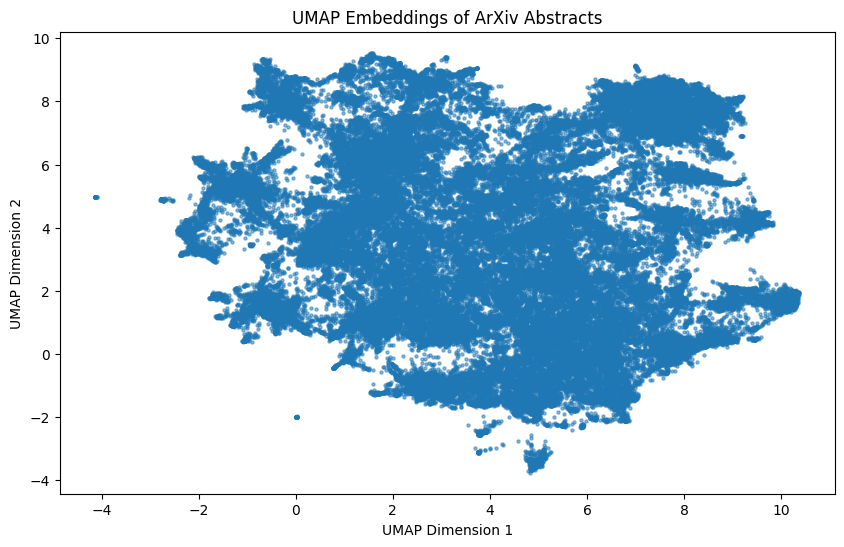

In [29]:
# UMAP
import umap
import matplotlib.pyplot as plt

# Create UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit the model to the abstract embeddings
umap_embeddings = umap_model.fit_transform(abstract_embeddings)

# Plot the UMAP embeddings
plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5, alpha=0.5)
plt.title('UMAP Embeddings of ArXiv Abstracts')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [41]:
# Load the abstract texts
with open('../data/vector_store_csLG/abstract_texts.json', 'r') as f:
    abstract_data = json.load(f)

In [42]:
abstract_data

{'doc_ids': ['0704.0671',
  '0704.0954',
  '0704.1020',
  '0704.1028',
  '0704.1274',
  '0704.1409',
  '0704.2092',
  '0704.2644',
  '0704.2668',
  '0705.0760',
  '0705.1585',
  '0705.2318',
  '0705.2765',
  '0705.4485',
  '0705.4566',
  '0706.0585',
  '0706.2040',
  '0706.3188',
  '0707.0498',
  '0707.0701',
  '0707.0704',
  '0707.0705',
  '0707.0805',
  '0707.1452',
  '0707.3087',
  '0707.3390',
  '0707.3479',
  '0708.0171',
  '0708.0654',
  '0708.1242',
  '0708.1503',
  '0708.1580',
  '0708.2319',
  '0708.2353',
  '0708.3226',
  '0709.0509',
  '0709.1516',
  '0709.2446',
  '0709.3427',
  '0709.3461',
  '0709.3586',
  '0709.3587',
  '0709.3639',
  '0709.3640',
  '0709.3965',
  '0709.3967',
  '0710.0485',
  '0710.2083',
  '0710.2446',
  '0710.2848',
  '0710.2889',
  '0710.5116',
  '0711.0189',
  '0711.1814',
  '0711.2023',
  '0711.2801',
  '0711.2914',
  '0711.3594',
  '0711.3675',
  '0711.4452',
  '0712.0130',
  '0712.0451',
  '0712.0653',
  '0712.0840',
  '0712.0938',
  '0712.1402',

In [43]:
hf_path = 'charlieoneill/cs.LG'

ds = load_dataset(hf_path)

In [52]:
import pandas as pd

# Create a new CSV dataset with just arxiv_id, title, citation_count, author and year
df_dict = {'arxiv_id': ds['train']['id'], 'title': ds['train']['title'], 'citation_count': [0]*len(ds['train']['id']), 'author': ds['train']['authors'], 'year': ds['train']['year']}
df = pd.DataFrame(df_dict)
# df.to_csv("sae_data/astro_paper_metadata.csv", index=False)
# Remove all rows where arxiv_id is None
df = df[df['arxiv_id'].notnull()]
df.head()

arxiv_id                                              title  \
0  0704.0671              Learning from compressed observations   
1  0704.0954  Sensor Networks with Random Links: Topology De...   
2  0704.1020  The on-line shortest path problem under partia...   
3  0704.1028    A neural network approach to ordinal regression   
4  0704.1274   Parametric Learning and Monte Carlo Optimization   

   citation_count                                             author  year  
0               0                                     Maxim Raginsky   NaN  
1               0                   Soummya Kar and Jose M. F. Moura   NaN  
2               0  Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...   NaN  
3               0                                      Jianlin Cheng   NaN  
4               0             David H. Wolpert and Dev G. Rajnarayan   NaN

In [54]:
import pandas as pd

def extract_year_month(arxiv_id):
    try:
        year = '20' + arxiv_id[:2]
        month = arxiv_id[2:4]
        return pd.Series({'year': int(year), 'month': int(month)})
    except:
        print(f"Error extracting year and month from arxiv_id: {arxiv_id}")

def process_arxiv_df(df):
    # Extract year and month from arxiv_id
    df[['year', 'month']] = df['arxiv_id'].apply(extract_year_month)
    return df

# Assuming your DataFrame is named 'df'
df = process_arxiv_df(df)

In [55]:
df.head()

arxiv_id                                              title  \
0  0704.0671              Learning from compressed observations   
1  0704.0954  Sensor Networks with Random Links: Topology De...   
2  0704.1020  The on-line shortest path problem under partia...   
3  0704.1028    A neural network approach to ordinal regression   
4  0704.1274   Parametric Learning and Monte Carlo Optimization   

   citation_count                                             author  year  \
0               0                                     Maxim Raginsky  2007   
1               0                   Soummya Kar and Jose M. F. Moura  2007   
2               0  Andras Gyorgy, Tamas Linder, Gabor Lugosi, Gyo...  2007   
3               0                                      Jianlin Cheng  2007   
4               0             David H. Wolpert and Dev G. Rajnarayan  2007   

   month  
0      4  
1      4  
2      4  
3      4  
4      4

In [56]:
# Save
df.to_csv('sae_data_csLG/astro_paper_metadata.csv', index=False)

## New dataset

In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset("charlieoneill/cs.LG")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'categories', 'abstract', 'authors', 'doi', 'id', 'year', 'venue'],
        num_rows: 141518
    })
})

In [4]:
ir = load_dataset("kiyer/arxiv_cs.LG")

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [5]:
ir

DatasetDict({
    train: Dataset({
        features: ['arxiv_id', 'title', 'abstract', 'link', 'authors', 'updated', 'published'],
        num_rows: 100000
    })
})

In [14]:
import pandas as pd
import ast

# Print sizes of original datasets
print(f"Size of 'ds' dataset: {len(ds['train'])}")
print(f"Size of 'ir' dataset: {len(ir['train'])}")

# Rename 'arxiv_id' to 'id' in the 'ir' dataset for consistency
ir_renamed = ir['train'].rename_column('arxiv_id', 'id')

# Convert datasets to pandas DataFrames for easier merging
ds_df = ds['train'].to_pandas()
ir_df = ir_renamed.to_pandas()

# Function to safely convert string representations of lists to actual lists
def safe_eval(val):
    if isinstance(val, list):
        return val
    elif isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except:
            return [val]
    else:
        return [str(val)]

# Apply safe_eval to authors columns
ds_df['authors'] = ds_df['authors'].apply(safe_eval)
ir_df['authors'] = ir_df['authors'].apply(safe_eval)

# Merge the datasets based on 'id'
merged_df = pd.merge(ds_df, ir_df, on='id', how='outer', suffixes=('_ds', '_ir'))

# Function to combine columns, preferring non-null values
def combine_columns(row, col1, col2):
    val1, val2 = row[col1], row[col2]
    if pd.notnull(val1) and pd.notnull(val2):
        if isinstance(val1, list) and isinstance(val2, list):
            return list(set(val1 + val2))  # Combine and remove duplicates
        else:
            return val1  # Prefer the first dataset's value if types don't match
    return val1 if pd.notnull(val1) else val2

# Combine similar columns
columns_to_combine = [
    ('title_ds', 'title_ir', 'title'),
    ('abstract_ds', 'abstract_ir', 'abstract'),
    ('authors_ds', 'authors_ir', 'authors')
]

for col1, col2, new_col in columns_to_combine:
    merged_df[new_col] = merged_df.apply(lambda row: combine_columns(row, col1, col2), axis=1)
    merged_df = merged_df.drop(columns=[col1, col2])

# Remove duplicates
deduplicated_df = merged_df.drop_duplicates(subset='id')

# Ensure all entries in the 'authors' column are lists
deduplicated_df['authors'] = deduplicated_df['authors'].apply(lambda x: x if isinstance(x, list) else [x])

# Convert back to a Hugging Face Dataset
from datasets import Dataset
deduplicated_dataset = Dataset.from_pandas(deduplicated_df)

# Print size of deduplicated dataset
print(f"Size of deduplicated dataset: {len(deduplicated_dataset)}")

# Create a new DatasetDict with the deduplicated dataset
from datasets import DatasetDict
deduplicated_ds_dict = DatasetDict({'train': deduplicated_dataset})

print("Merge and deduplication complete.")
print(f"Columns in the final dataset: {deduplicated_dataset.column_names}")

Size of 'ds' dataset: 141518
Size of 'ir' dataset: 100000


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_60157/4040402119.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deduplicated_df['authors'] = deduplicated_df['authors'].apply(lambda x: x if isinstance(x, list) else [x])


Size of deduplicated dataset: 153146
Merge and deduplication complete.
Columns in the final dataset: ['categories', 'doi', 'id', 'year', 'venue', 'link', 'updated', 'published', 'title', 'abstract', 'authors', '__index_level_0__']


In [16]:
# Count of deduplicated df where id is None
print(f"Number of rows with missing 'id': {deduplicated_df['id'].isnull().sum()}")

Number of rows with missing 'id': 1


In [20]:
ids = list(deduplicated_df.id.unique())
# Count how many have a full stop in them
count = 0
for i in ids:
    try:
        if '.' in i:
            print(i)
            count += 1
    except:
        pass
print(f"Number of IDs with a full stop: {count}")

0704.0671
0704.0954
0704.1020
0704.1028
0704.1274
0704.1409
0704.2092
0704.2644
0704.2668
0705.0760
0705.1585
0705.2318
0705.2765
0705.4485
0705.4566
0706.0585
0706.2040
0706.3188
0706.3679
0707.0498
0707.0701
0707.0704
0707.0705
0707.0805
0707.1452
0707.3087
0707.3390
0707.3479
0708.0171
0708.0654
0708.1242
0708.1503
0708.1580
0708.2319
0708.2353
0708.3226
0709.0509
0709.1516
0709.2446
0709.3427
0709.3461
0709.3586
0709.3587
0709.3639
0709.3640
0709.3965
0709.3967
0710.0485
0710.2083
0710.2446
0710.2848
0710.2889
0710.5116
0711.0189
0711.1814
0711.2023
0711.2801
0711.2914
0711.3594
0711.3675
0711.4452
0712.0130
0712.0451
0712.0653
0712.0840
0712.0938
0712.1402
0712.2497
0712.2869
0712.3402
0712.3654
0712.3807
0712.4273
0801.0390
0801.1988
0801.2069
0801.4061
0801.4790
0801.4794
0802.1002
0802.1244
0802.1258
0802.1430
0802.2015
0802.2158
0802.2305
0802.2428
0802.2655
0802.3789
0803.0924
0803.1555
0803.2856
0803.3490
0803.3838
0804.0188
0804.0924
0804.1302
0804.1441
0804.3575
0804.3817


In [15]:
deduplicated_df

categories   doi       id    year venue  \
0             NaN   NaN  0001004     NaN   NaN   
1             NaN   NaN  0001008     NaN   NaN   
2             NaN   NaN  0001027     NaN   NaN   
3             NaN   NaN  0002006     NaN   NaN   
4             NaN   NaN  0003072     NaN   NaN   
...           ...   ...      ...     ...   ...   
153142        NaN   NaN  9908014     NaN   NaN   
153143        NaN   NaN  9910011     NaN   NaN   
153144        NaN   NaN  9912008     NaN   NaN   
153145        NaN   NaN  9912016     NaN   NaN   
153146       None  None     None  2023.0  cvpr   

                                     link               updated  \
0       http://arxiv.org/pdf/cs/0001004v1  2000-01-07T06:20:53Z   
1       http://arxiv.org/pdf/cs/0001008v3  2003-06-20T14:20:48Z   
2       http://arxiv.org/pdf/cs/0001027v1  2000-01-29T01:23:54Z   
3       http://arxiv.org/abs/cs/0002006v1  2000-02-09T06:44:28Z   
4       http://arxiv.org/pdf/cs/0003072v1  2000-03-22T12:49:38Z   
...                                   ...                   ...   
153142  http://arxiv.org/pdf/cs/9908014v1  1999-08-17T22:49:19Z   
153143  http://arxiv.org/pdf/cs/9910011v1  1999-10-13T03:25:33Z   
153144  http://arxiv.org/pdf/cs/9912008v2  2001-01-26T18:45:28Z   
153145  http://arxiv.org/pdf/cs/9912016v1  1999-12-23T01:07:33Z   
153146                                NaN                   NaN   

                   published  \
0       2000-01-07T06:20:53Z   
1       2000-01-12T20:57:59Z   
2       2000-01-29T01:23:54Z   
3       2000-02-09T06:44:28Z   
4       2000-03-22T12:49:38Z   
...                      ...   
153142  1999-08-17T22:49:19Z   
153143  1999-10-13T03:25:33Z   
153144  1999-12-13T08:33:43Z   
153145  1999-12-23T01:07:33Z   
153146                   NaN   

                                                    title  \
0       Multiplicative Algorithm for Orthgonal Groups ...   
1       Predicting the expected behavior of agents tha...   
2           Pattern Discovery and Computational Mechanics   
3       Multiplicative Nonholonomic/Newton -like Algor...   
4       MOO: A Methodology for Online Optimization thr...   
...                                                   ...   
153142         An Introduction to Collective Intelligence   
153143  A statistical model for word discovery in chil...   
153144         New Error Bounds for Solomonoff Prediction   
153145   HMM Specialization with Selective Lexicalization   
153146                 Train-Once-for-All Personalization   

                                                 abstract  \
0       The multiplicative Newton-like method develope...   
1       We describe a framework and equations used to ...   
2       Computational mechanics is a method for discov...   
3       We construct new algorithms from scratch, whic...   
4       Ports, warehouses and courier services have to...   
...                                                   ...   
153142  This paper surveys the emerging science of how...   
153143  A statistical model for segmentation and word ...   
153144  Solomonoff sequence prediction is a scheme to ...   
153145  We present a technique which complements Hidde...   
153146  We study the problem of how to train a "person...   

                                                  authors  
0                                  [['Toshinao Akuzawa']]  
1                  [['Jose M. Vidal' 'Edmund H. Durfee']]  
2       [['Cosma Rohilla Shalizi' 'James P. Crutchfiel...  
3                  [['Toshinao Akuzawa' 'Noboru Murata']]  
4       [['Jason W. H. Lee' 'Y. C. Tay' 'Anthony K. H....  
...                                                   ...  
153142               [['David H. Wolpert' 'Kagan Tumer']]  
153143                           [['Anand Venkataraman']]  
153144                                [['Marcus Hutter']]  
153145  [['Jin-Dong Kim' 'Sang-Zoo Lee' 'Hae-Chang Rim']]  
153146  [Hong-You Chen, Yandong Li, Yin Cui, Mingda Zh...  

[153146 rows x 11 columns]

In [11]:
deduplicated_dataset

Dataset({
    features: ['title_ds', 'categories', 'abstract_ds', 'authors_ds', 'doi', 'id', 'year', 'venue', 'title_ir', 'abstract_ir', 'link', 'authors_ir', 'updated', 'published', '__index_level_0__'],
    num_rows: 153146
})

In [9]:
deduplicated_ds_dict

DatasetDict({
    train: Dataset({
        features: ['title_ds', 'categories', 'abstract_ds', 'authors_ds', 'doi', 'id', 'year', 'venue', 'title_ir', 'abstract_ir', 'link', 'authors_ir', 'updated', 'published', '__index_level_0__'],
        num_rows: 153146
    })
})

In [22]:
deduplicated_dataset = deduplicated_dataset.remove_columns(['__index_level_0__'])

In [23]:
deduplicated_dataset.push_to_hub('charlieoneill/csLG')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/154 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/806 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/charlieoneill/csLG/commit/5f3d9b3914540af8f482fa166637c12ab8ffdbcb', commit_message='Upload dataset', commit_description='', oid='5f3d9b3914540af8f482fa166637c12ab8ffdbcb', pr_url=None, pr_revision=None, pr_num=None)